# Introducción
En este proyecto desarrollamos un sistema de clasificación automática para predecir el estado de ánimo (mood) de canciones en base a sus características sonoras. El objetivo es construir modelos de machine learning que, a partir de variables como la danzabilidad, la energía, la valencia, el tempo, entre otras, sean capaces de identificar a qué tipo de mood pertenece una canción.

El flujo general del trabajo se divide en varias etapas:

*  Preprocesamiento de datos: limpiamos el conjunto de datos original y normalizamos sus características mediante StandardScaler para asegurar una correcta interpretación por parte de los modelos.

*  Generación de etiquetas con KMeans: como no contamos con etiquetas de mood en el dataset original, aplicamos un algoritmo de clustering (KMeans) para agrupar las canciones en distintos estados de ánimo. Cada canción recibe una etiqueta basada en el clúster al que pertenece.

*  Clasificación supervisada: con estas nuevas etiquetas, transformamos el problema en uno de clasificación supervisada. Entrenamos y comparamos cuatro modelos distintos:
    *  Random Forest
    *  K-Nearest Neighbors (KNN)
    *  Regresión Logística
    *  Máquinas de Vectores de Soporte (SVM)

Cada modelo es ajustado mediante GridSearchCV para encontrar la mejor combinación de hiperparámetros utilizando validación cruzada. Luego se evalúa su rendimiento sobre un conjunto de prueba mediante métricas como accuracy, classification report y matriz de confusión.

* Evaluación y visualización: finalmente, analizamos los resultados de cada modelo para determinar cuál es más eficaz en la tarea de clasificación. También visualizamos gráficamente los resultados y comparamos las predicciones con las etiquetas reales.

In [109]:
# Imports
import sys
import os

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from kneed import KneeLocator
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import time
import logging
import joblib

# [Alex] Define the paths of the data here?
# [Alex] Add requirements.txt and install all modules

## Análisis de los datos

In [110]:
# Cargar el dataset
in_spotify_dataset = './Source/tracks.csv'

df_tracks = pd.read_csv(in_spotify_dataset)
print(f"{df_tracks.head()}")

                       id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechine

Con la función head podemos ver cada una de las columans que forman el dataset. A continuación, se explica la información que obtenemos de cada una de ellas:

* id: Identificador único de cada canción proporcionado por Spotify.
* name: Nombre o título de la canción.
* popularity: Popularidad actual de la canción en Spotify (0 = menos popular, 100 = más popular).
* duration_ms: Duración de la canción en milisegundos.
* explicit: Indica si la canción contiene contenido explícito (1 = explícito, 0 = no explícito).
* artists: Nombre(s) del artista(s) que interpretan la canción.
* id_artists: Identificadores únicos en Spotify de los artistas correspondientes.
* release_date: Fecha en la que se lanzó originalmente la canción (formato YYYY-MM-DD).
* danceability: Qué tan adecuada es una canción para bailar (0.0 = menos bailable, 1.0 = más bailable).
* energy: Energía y nivel de actividad percibido en la canción (0.0 = menos energética, 1.0 = más energética).
* key: Tono o clave musical en la que está compuesta la canción (valores numéricos de 0 a 11 que corresponden a notas musicales).
* loudness: Volumen promedio de la canción en decibelios (dB).
* mode: Modalidad de la canción (0 = menor, 1 = mayor).
* speechiness: Medida de cuánto contenido hablado tiene una canción (0.0 = poca o ninguna, cerca de 1.0 = predominantemente hablada).
* acousticness: Indica qué tan acústica es la canción (0.0 = menos acústica, 1.0 = muy acústica).
* instrumentalness: Indica la probabilidad de que una canción sea instrumental (más cercano a 1.0 significa mayor probabilidad instrumental, 0.0 es típicamente vocal).
* liveness: Indica la probabilidad de que la canción haya sido grabada en vivo (más cercano a 1.0 indica alta probabilidad de que sea en vivo).
* valence: Indica la positividad o felicidad que transmite una canción (0.0 = más triste o negativa, 1.0 = más alegre o positiva).
* tempo: Velocidad o ritmo de la canción medida en BPM (pulsos por minuto).
* time_signature: Número de pulsos por compás en la canción (por ejemplo: 4 indica compás de 4/4).


A continuación, comprobamos el número de columnas y filas que conforman nuestro dataset:

In [111]:

print(f"Shape de df_tracks:\n{df_tracks.shape}")

print(f"Info de df_tracks:\n{df_tracks.info()}")

Shape de df_tracks:
(586672, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  

Podemos ver que el fichero a estudiar tiene 586672 canciones con 20 columnas con la información de cada una.
Para conocer el tipo de dato de cada columna y su nulabilidad utilizamos la función info():


Gracias al resultado anterior, podemos deducir lo siguiente:
* El dataset tiene un total de 586,672 registros (filas).
* Posee 20 columnas.
* La mayoría de columnas están completas, con pocos datos faltantes:
  * Solo la columna "name" tiene valores nulos (71 valores faltantes).
* Los tipos de datos incluyen:
  *  texto: id, name, artists, id_artists, release_date
  *  números enteros: popularity, duration_ms, explicit, key, mode, time_signature
  *  números decimales: danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo
* El dataset utiliza aproximadamente 89.5 MB de memoria


Puesto que el propósito del proyecto es conocer el mood de cada una de las canciones del dataset para poder recomendar al usuario según su estado anímico, es necesario quedarnos exclusivamente con las features que aporten un significado a la variable objetivo (mood). Para ello, vamos a analizar una a una para conocer el listado final de features a utilizar para obtener el mood de cada canción.



| Columna           | Útil para el mood | Razón concreta                                                                                   |
|-------------------|-------------------|--------------------------------------------------------------------------------------------------|
| id                | ❌                | Identificador único, no contiene información emocional o musical.                               |
| name              | ❌                | Es solo el título de la canción, no representa características de audio o emoción.              |
| popularity        | ❌                | Es un indicador social, no emocional ni acústico.                                                |
| duration_ms       | ❌                | La duración no determina directamente el estado de ánimo.                                       |
| explicit          | ❌                | Indica lenguaje explícito, no es un indicador directo del mood musical.                         |
| artists           | ❌                | Nombre del artista no describe directamente el sonido o emoción de la canción.                  |
| id_artists        | ❌                | Es un identificador técnico, sin relación con el mood.                                          |
| release_date      | ❌                | La fecha de publicación no describe el tono emocional o características del audio.              |
| danceability      | ✅                | Describe qué tan fácil es bailar la canción, influye directamente en el mood.                   |
| energy            | ✅                | Cuantifica la intensidad de la canción, clave en la percepción emocional.                       |
| key               | ❌                | Es la nota musical base, pero no determina por sí sola el estado de ánimo.                      |
| loudness          | ✅                | Canciones más fuertes suelen sentirse más energéticas o intensas.                               |
| mode              | ❌                | Indica mayor o menor, pero es una característica muy general del tono.                          |
| speechiness       | ✅                | Ayuda a distinguir canciones habladas o rapeadas, cambia la percepción emocional.               |
| acousticness      | ✅                | Cuantifica si es acústica; sonidos acústicos suelen sentirse más suaves o íntimos.              |
| instrumentalness  | ✅                | Alta instrumentalidad suele asociarse con calma o ambiente.                                     |
| liveness          | ✅                | Indica si fue grabada en vivo; puede transmitir diferentes emociones.                           |
| valence           | ✅                | Describe qué tan positiva o alegre es la canción, directamente ligado al mood.                  |
| tempo             | ✅                | Ritmo de la canción, afecta energía y sensación emocional.                                      |
| time_signature    | ❌                | Es la métrica musical; tiene poco impacto en cómo percibimos el mood.                          |


[Alex] Understand what are the final features and why?, 

Una vez analizadas las columnas del dataset, las features interesantes a utilizar son:
* danceability
*  energy
*  loudness
*  speechiness
*  acousticness
*  instrumentalness
*  liveness
*  valence
*  tempo

Con estas features ya podemos hacer uso de la función clean_normalize_dataset() que hemos creado en el fichero final_models.py. 

Esta función clean_normalize_dataset realiza tres tareas principales sobre un conjunto de datos:

*  Carga y limpieza: Lee el archivo CSV de entrada (tracks.csv), escoge las columnas que hemos seleccionado (FEATURES) y elimina las filas con valores nulos.

*  Normalización: Escala los datos numéricos usando StandardScaler para que tengan media 0 y desviación estándar 1. Este proceso mejora el rendimiento de muchos algoritmos de machine learning y evita que variables con valores grandes dominen sobre otras más pequeñas.

*  Guardado de resultados: primero guarda el objeto escalador (scaler) como archivo .pkl por si lo tenemos que utilizar de nuevo, y también guarda el nuevo dataset normalizado como archivo .csv.

A continuación, usamos esta función y observamos los resultados:

In [117]:
data_scaled_pkl = './Data/data_scaled.pkl'

# Process dataset
def clean_normalize_dataset(input_csv: str, scaled_output_pkl: str):

    start_time = time.time()
    print(f"Clean and Normalize Dataset")

    # Features
    old_features = ['energy','tempo','loudness','danceability','valence']
    new_features = ['arousal','valence']

    # Load the data and clean it (drop missing values)
    df = pd.read_csv(input_csv)
    print(f"Shape Original: {df.shape}")
    print(f"Missing data before cleanup: {df[old_features].isnull().sum().sum()} entries.")
    df = df[old_features].dropna().copy()
    print(f"Original Data Description:\n{df.describe()}")
    print(f"First few rows of the scaled data:\n{df.head()}")

    # Initialize the data_scaled DataFrame
    data_scaled = df.copy()

    # Define scaling ranges for specific features
    scale_ranges = {
        'tempo': (20, 200),
        'loudness': (-60, 0),
        'energy': (0, 1),
        'danceability': (0, 1)
    }

    # Clip the tempo and loudness values to ensure they stay within the expected ranges
    data_scaled['tempo'] = data_scaled['tempo'].clip(lower=20, upper=200)
    data_scaled['loudness'] = data_scaled['loudness'].clip(lower=-60, upper=0)
    data_scaled['energy'] = data_scaled['energy'].clip(lower=0, upper=1)
    data_scaled['danceability'] = data_scaled['danceability'].clip(lower=0, upper=1)

    # Apply MinMax scaling for each feature
    for feature, (min_input, max_input) in scale_ranges.items():
        min_output = 0
        max_output = 1
        data_scaled[feature] = (data_scaled[feature] - min_input) / (max_input - min_input) * (max_output - min_output) + min_output

    # Round the values to 3 decimal places
    data_scaled = data_scaled.round(3)

    # Log the description after scaling
    print(f"Scaled Data Description:\n{data_scaled.describe()}")

    # Define the weights for the features
    alpha = 0.5  # Energy has more influence on arousal
    beta = 0.25  # Tempo is still important, but less than energy
    gamma = 0.2  # Loudness is less important, but still relevant
    delta = 0.05  # Danceability plays the least role in arousal
    
    # Calculate the arousal score (weighted sum of selected features)
    data_scaled['arousal'] = (alpha * data_scaled['energy']) + \
                             (beta * data_scaled['tempo']) + \
                             (gamma * data_scaled['loudness']) + \
                             (delta * data_scaled['danceability'])
    
    # Round the values for arousal
    data_scaled = data_scaled.round(3)

    # Log the description after calculating arousal
    print(f"Data with Arousal Score Description:\n{data_scaled.describe()}")
    print(f"First few rows of the scaled data:\n{data_scaled.head()}")

    # Select the relevant columns (valence and arousal)
    scaled_df = data_scaled[new_features].dropna().copy()
    print(f"Shape Save: {df.shape}")

    # Save the cleaned and scaled DataFrame to a pickle file
    scaled_df.to_pickle(scaled_output_pkl)

    print(f"Completed in {time.time() - start_time:.2f} seconds")

clean_normalize_dataset(in_spotify_dataset, data_scaled_pkl)

Clean and Normalize Dataset
Shape Original: (586672, 20)
Missing data before cleanup: 0 entries.
Original Data Description:
              energy          tempo       loudness   danceability  \
count  586672.000000  586672.000000  586672.000000  586672.000000   
mean        0.542036     118.464857     -10.206067       0.563594   
std         0.251923      29.764108       5.089328       0.166103   
min         0.000000       0.000000     -60.000000       0.000000   
25%         0.343000      95.600000     -12.891000       0.453000   
50%         0.549000     117.384000      -9.243000       0.577000   
75%         0.748000     136.321000      -6.482000       0.686000   
max         1.000000     246.381000       5.376000       0.991000   

             valence  
count  586672.000000  
mean        0.552292  
std         0.257671  
min         0.000000  
25%         0.346000  
50%         0.564000  
75%         0.769000  
max         1.000000  
First few rows of the scaled data:
   energy   

In [113]:
df_tracks_cleaned = joblib.load(data_scaled_pkl)

print(f"\nShape: {df_tracks_cleaned.shape}")

print(f"\nInformation\n: {df_tracks_cleaned.info()}") #Why None
print(f"\nDescription\n: {df_tracks_cleaned.describe()}")


Shape: (586672, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   arousal  586672 non-null  float64
 1   valence  586672 non-null  float64
dtypes: float64(2)
memory usage: 9.0 MB

Information
: None

Description
:              arousal        valence
count  586672.000000  586672.000000
mean        0.617377       0.552293
std         0.137892       0.257671
min         0.000000       0.000000
25%         0.520000       0.346000
50%         0.629000       0.564000
75%         0.726000       0.769000
max         0.944000       1.000000


Vemos que en el dataset resultante no quedan valores nulos en ninguna de las columnas, y con la función describe() podemos ver el resultado de la normalización:

array([[<Axes: title={'center': 'arousal'}>,
        <Axes: title={'center': 'valence'}>]], dtype=object)

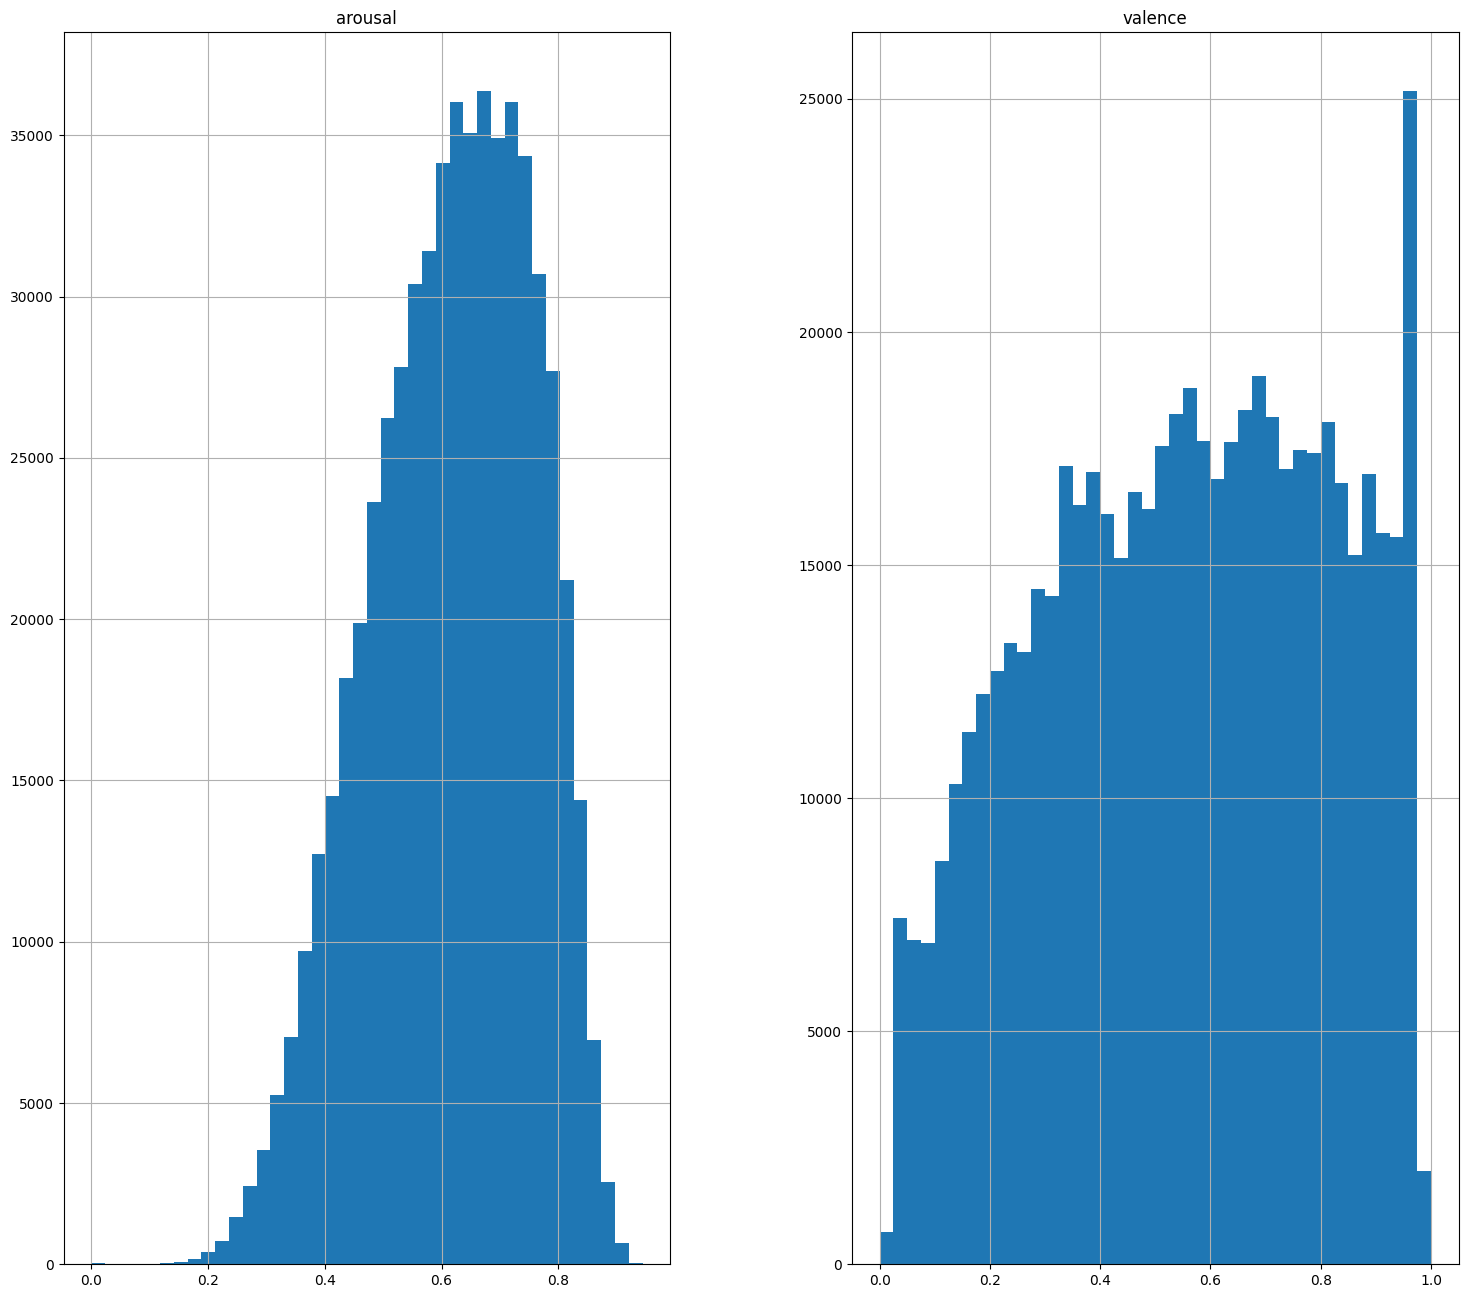

In [114]:
df_tracks_cleaned.hist(bins= 40, figsize= (18 , 16))

Con la función hist() aplicada a nuestro dataset podemos observar las distribuciones de los valores de cada feature para todas las canciones, pudiendo identificar los outliers. Sin embargo, en datasets musicales como este, los valores extremos no necesariamente son errores ni datos atípicos indeseables, sino que pueden representar características reales e importantes de ciertos géneros musicales o canciones únicas.

Algunas variables como danceability, tempo, valence o energy tienen distribuciones más o menos normales. Otras como speechiness, instrumentalness, liveness, muestran colas largas o concentraciones extremas, lo cual es esperado y válido en audio/música. Por ejemplo, Speechiness puede estar muy cerca de 0 para música instrumental y cerca de 1 para hip hop. Otro ejemplo, puede ser para Instrumentalness que puede tener valor 0 para canciones vocales y valor muy alto en canciones sin voz.

A continuación, vamos a representar la Matriz de correlación. Con esta podemos ver la relación entre las distintas features que conforman nuestro dataset. En caso de que hubiera una gran relación entre varias, podríamos prescindir de una de ellas al tener valores muy similares. 



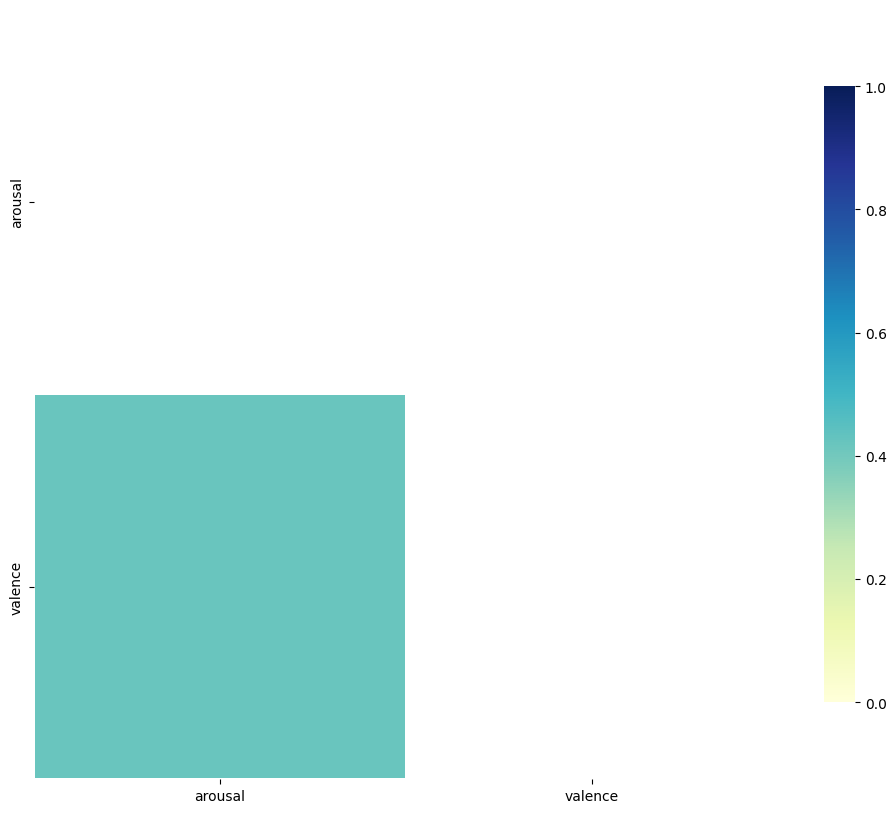

In [115]:
# Compute the correlation matrix
corr = np.abs(df_tracks_cleaned.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin=0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

# Show the plot
plt.show()

Como resultado, podemos decir que los valores de correlación (color más oscuro) están todos por debajo de 0.7, lo cual indica:
*  No hay variables altamente correlacionadas entre sí (lo que justificaría eliminar alguna por redundancia).
*  Cada feature parece aportar información distinta.

En el caso, por ejemplo, de energy y loudness, tienen la correlación más alta (aproximadamente 0.6), lo cual es lógico ya que la música enérgica tiende a sonar más fuerte, pero no es suficiente como para considerar una de las dos innecesaria.

Otro ejemplo, son las variables como speechiness, instrumentalness, liveness tienen correlaciones muy bajas con casi todo lo demás, lo que significa que están capturando aspectos únicos.

En este caso, no tenemos que eliminar ninguna variable porque no hay una correlación fuerte ni redundancia evidente entre ninguna de las variables. Eliminaríamos una variable en caso de que la correlación con otra fuera igual o mayor a 0.9.

## K-means

KMeans es un algoritmo de aprendizaje no supervisado que agrupa datos similares en k grupos llamados clústeres. Funciona ubicando centros (centroides) en el espacio de los datos y asignando cada punto al centro más cercano, ajustando esos centros hasta estabilizar los grupos.

Para este caso, puesto que queremos clasificar canciones en un mood concreto, KMeans las agrupa según tengan perfiles similares (por ejemplo, energía alta y valence bajo), lo que permite identificar distintos "moods" musicales sin etiquetas previas. Así podremos clasificar cada canción automáticamente en grupos como por ejemplo, alegres, tristes, relajadas o intensas, según sus características sonoras.

Primero vamos a comprobar cuál es el número óptimo de clusters para este caso utilizando el método codo. El método codo funciona trazando la variación dentro del cluster en función del número de clusters. La idea es elegir el número de clusters de modo que al agregar otro cluster no se reduzca sustancialmente la variación dentro del cluster. Esto produce un gráfico donde la disminución de la variación será grande para los primeros clusters, y luego se estabilizará, creando un "codo" en el gráfico. El codo nos indicará el número de clusters a escoger, teniendo en cuenta que cada cluster representa un mood musical.

#### Trying to figure out what is the optimal k, with different algorithms 

Running Kmeans k = [4, 5, 6, 7, 8] Clusters

Running K-Means for k=4


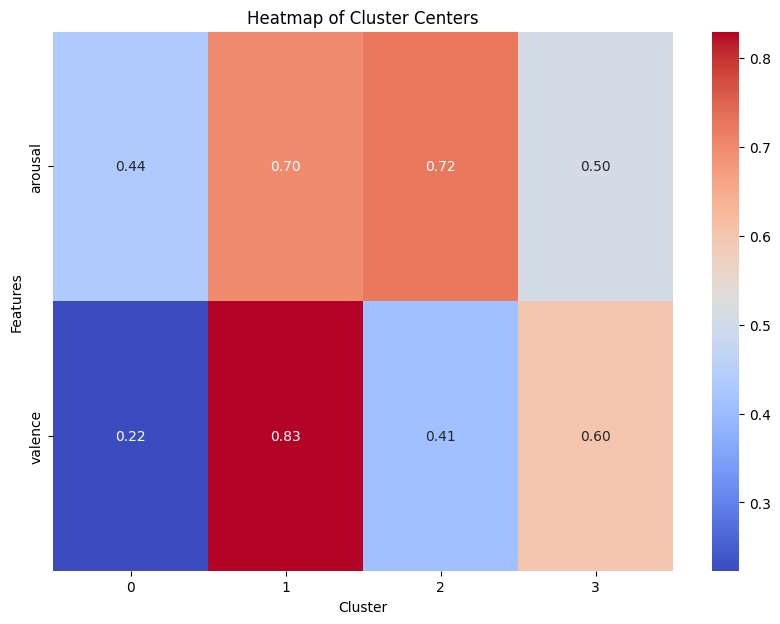

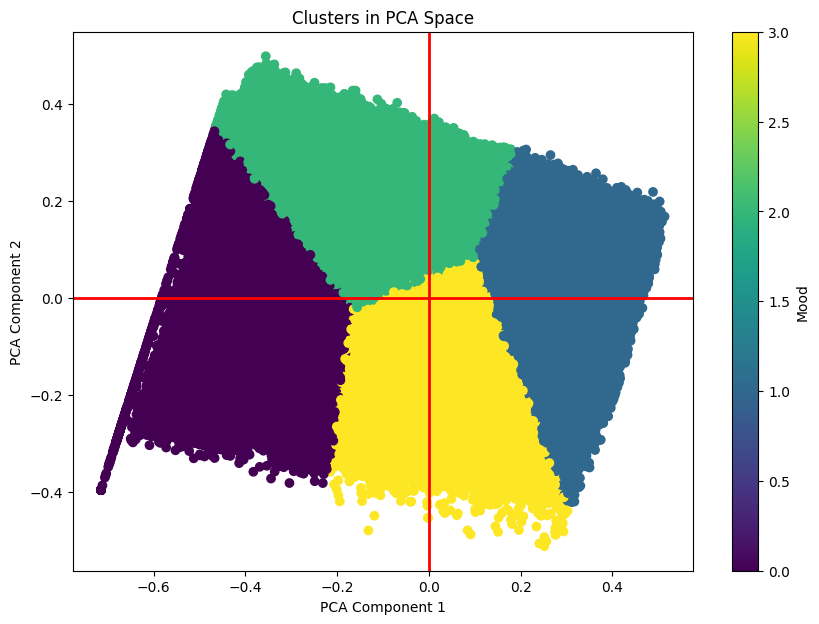

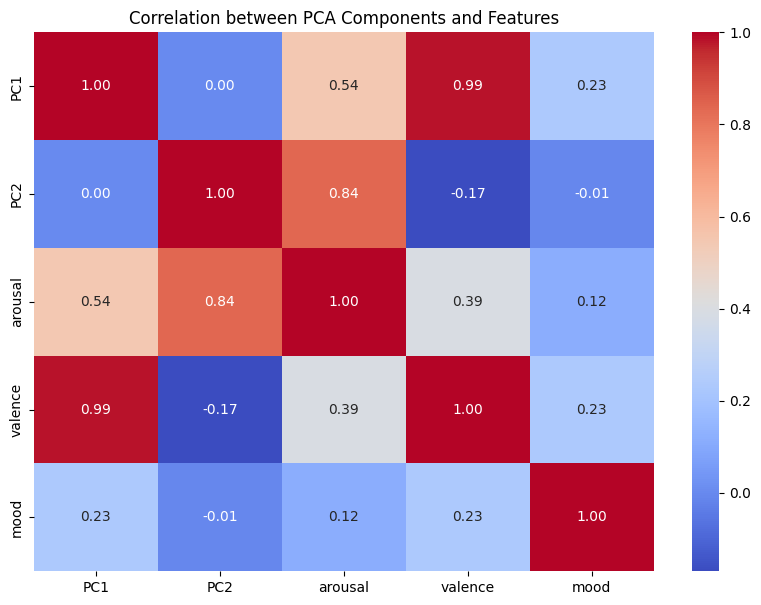

Completed K-Means for k=4 in 32.34 seconds


Running K-Means for k=5


KeyboardInterrupt: 

In [121]:
data_scaled_for_kmeans = joblib.load(data_scaled_pkl)

num_rows, num_columns = data_scaled_for_kmeans.shape
sample_sil = round((num_rows-1)*0.05) #5% Dataset

wcss_results = []
sil_results = []
ch_results = []
db_results = []

k_range = range(4, 9)
print(f"Running Kmeans k = {list(k_range)} Clusters")
for k in k_range:
    print(f"\nRunning K-Means for k={k}")
    start_time = time.time()

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit_predict(data_scaled_for_kmeans)

    wcss_results.append(kmeans.inertia_)
    sil_score = silhouette_score(
        data_scaled_for_kmeans,
        kmeans.labels_,
        metric='euclidean',
        sample_size=sample_sil, 
        random_state=42,
        n_jobs=-1
    )
    sil_results.append(sil_score)
    ch_score = calinski_harabasz_score(data_scaled_for_kmeans, kmeans.labels_)
    ch_results.append(ch_score)
    db_score = davies_bouldin_score(data_scaled_for_kmeans, kmeans.labels_)
    db_results.append(db_score)

    data_scaled_for_kmeans['mood'] = kmeans.labels_

    # 1. Plotting the heatmap of the clusters first (based on mood)
    plt.figure(figsize=(10, 7))
    sns.heatmap(data_scaled_for_kmeans.groupby('mood').mean().T, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Heatmap of Cluster Centers')
    plt.ylabel('Features')
    plt.xlabel('Cluster')
    plt.show()

    # 2. Plotting the clusters in PCA space (after the heatmap)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_scaled_for_kmeans[['arousal','valence']])
    plt.figure(figsize=(10, 7))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data_scaled_for_kmeans['mood'], cmap='viridis')
    plt.title('Clusters in PCA Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.axhline(0, color='r', linewidth=2)
    plt.axvline(0, color='r', linewidth=2)
    plt.colorbar(label='Mood')
    plt.show()

    # 3. Plotting the heatmap of the correlation between PCA components and features
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df = pd.concat([pca_df, data_scaled_for_kmeans], axis=1)
    correlation_matrix = pca_df.corr()
    plt.figure(figsize=(10, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation between PCA Components and Features")
    plt.show()

    print(f"Completed K-Means for k={k} in {time.time() - start_time:.2f} seconds\n")

# Print the results
results_kmeans = pd.DataFrame({
    'k': list(k_range),
    'WCSS': wcss_results,
    'Silhouette Score': sil_results,
    'Calinski-Harabasz': ch_results,
    'Davies-Bouldin': db_results
})


 k        WCSS  Silhouette Score  Calinski-Harabasz  Davies-Bouldin
 2 16926.17662           0.51790       1.030182e+06         0.68966
 3 12632.72381           0.63185       4.177674e+06         0.71730
 4  8525.23574           0.62835       1.082136e+07         0.54965
 5  7332.29625           0.74029       1.447223e+07         0.50271
 6  6321.34233           0.78036       2.097727e+07         0.45219
 7  5356.49906           0.75047       2.382825e+07         0.39931
 8  4740.70397           0.74601       3.771170e+07         0.40808
 9  4315.52584           0.84702       5.128799e+07         0.30924
10  3963.06136           0.83237       5.415656e+07         0.30290
11  3661.91699           0.83116       6.740203e+07         0.27905
12  3322.84521           0.83503       7.624281e+07         0.25239
13  3049.15075           0.84869       1.265902e+08         0.25937
14  2821.69032           0.85060       1.215990e+08         0.25407
15  2609.31642           0.87731       1.399976

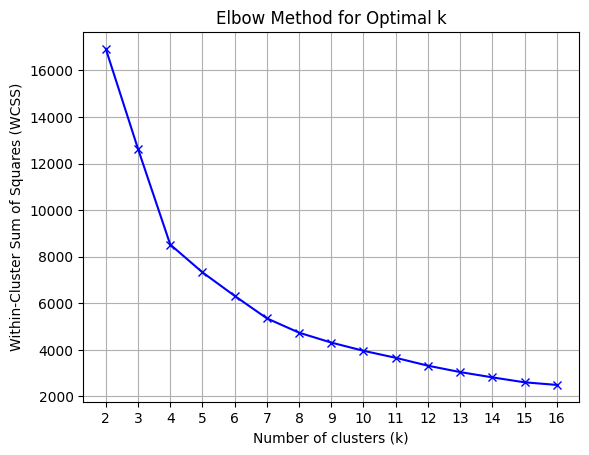

In [ ]:
# Print Results of the Kmeans
print(f"\n{results_kmeans.round(5).to_string(index=False)}\n")

# Find the best k for each metric
best_k_wcss = results_kmeans.loc[results_kmeans['WCSS'].idxmin()]['k']
best_k_silhouette = results_kmeans.loc[results_kmeans['Silhouette Score'].idxmax()]['k']
best_k_calinski = results_kmeans.loc[results_kmeans['Calinski-Harabasz'].idxmax()]['k']
best_k_davies = results_kmeans.loc[results_kmeans['Davies-Bouldin'].idxmin()]['k']
best_k_knee = KneeLocator(list(k_range), wcss_results, curve='convex', direction='decreasing',S=10)

# Print the results
print(f"Best k based on WCSS: k = {best_k_wcss}")
print(f"Best k based on Silhouette Score: k = {best_k_silhouette}")
print(f"Best k based on Calinski-Harabasz: k = {best_k_calinski}")
print(f"Best k based on Davies-Bouldin: k = {best_k_davies}")
print(f"Best k based on KneeLocator: k = {best_k_knee.knee}")

# Plotting the Elbow Method
plt.plot(list(k_range), wcss_results, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid()

# Display the plot
plt.show()

# chat gpt response

Cluster Labeling Strategy:

Cluster 0 (red)

Valence: High (0.81)
Energy: High (0.75)
Danceability: High (0.74)
Tempo: Low (-0.05)
Loudness: Moderate (0.62)

Interpretation: This cluster has high energy, high valence, and good danceability, indicating an "Energetic" or "Upbeat" mood.


Cluster 1 (blue)

Valence: Low (-1.20)
Energy: Very low (-1.30)
Danceability: Low (-1.17)
Tempo: Low (-0.54)
Loudness: Low (-1.28)

Interpretation: This cluster has low values across energy, valence, and danceability, suggesting a "Sad" or "Calm" mood, possibly a "Relaxed" cluster.


Cluster 2 (orange)

Valence: Moderate (0.07)
Energy: Moderate (-0.61)
Danceability: Moderate (0.34)
Tempo: Low (-0.41)
Loudness: Low (-0.44)

Interpretation: This cluster might reflect a "Neutral" mood, neither highly energetic nor sad.


Cluster 3 (light blue)

Valence: Low (-0.38)
Energy: High (0.55)
Danceability: Low (-0.61)
Tempo: High (0.90)
Loudness: Moderate (0.52)

Interpretation: This cluster could be "Intense" or "Dynamic" with high tempo and energy but low danceability, possibly a more dramatic mood.


Suggested Labels for the Clusters:

Cluster 0: Energetic/Upbeat
Cluster 1: Sad/Calm
Cluster 2: Neutral/Chill
Cluster 3: Intense/Dramatic

In [45]:
# [Alex] Explain the election of the K
k_optimal = 4

Podemos ver que el codo en este caso se forma en el cluster número 6, por lo que ejecutaremos el algoritmo K-means con k=6.

#### Aplicación de KMeans y asignación de clusters
Para la aplicación del algoritmo KMeans, se ha creado la función train_knn en el fichero final_models.py. El código de esta función es el siguiente:

```python
pegar código aqui!!!!!!!!!
```

[Alex] To decide the cluster and labels

Interpretar los Clusters (mood)
Vamos a analizar los patrones en la tabla de características promedio por mood.

📌 Algunas observaciones del heatmap:

*  Mood 0 - Fiestero : Alta energía, alto danceability, alta loudness. Ideal para fiestas y momentos activos.
*  Mood 1 - Melancólico: Baja energía, alto acousticness, menor danceability. Son canciones más tranquilas y sentimentales.
*  Mood 2 - Alegre: Energía moderada, buena danceability y valence alto. Transmite positividad.
*  Mood 3 - Triste: Baja energía, alto instrumentalness, baja loudness. Música más suave y profunda.
*  Mood 4 - Motivador: Alta energía y loudness, buen balance entre danceability y valence. Perfecto para entrenamientos o motivación.
*  Mood 5 - Relajado: Baja a moderada energía, mezcla de acousticness y danceability equilibrada. Ideal para 
momentos de descanso.



# Distintos modelos de clasificación
En este caso, al usar el KMeans hemos hecho un aprendizaje no supervisado, ya que nuestro algoritmo ha agrupado las canciones en clusters teniendo en cuenta solo las features de las canciones. Entonces, se han creado los clusters en base a la similitud entre las canciones y nosotros hemos interpretado estos clusters como "moods" y los usamos como una nueva etiqueta de las canciones. 
Sin embargo, una vez que cada canción tiene asignado un mood, ahora tenemos que predecir ese mood a partir de las features. AHora tenemos unos datos de entrada (las features) y una salida conocida (los moods asignados por KMeans) y queremos que los modelos aprendan a predecir esa clase a partir de ejemplos. Debido a esto, nos encontramos ante un problema de claisifcación supervisada:
*  Supervisada: porque tenemos una etiqueta conocida, el mood, para cada ejemplo.
*  Clasificación: porque esa etiqueta es categórica (Mood 0, 1, 2, 3, 4, 5 o 6).

Sabiendo que nos encontramos ante un problema de clasificación supervisada, vamos a entrenar el dataset con distintos modelos para analizarlos y ver cuál es mejor en este caso. 
Se van a estudiar cuatro modelos de clasificación sueprvisada: Random Forest, Knn, Regresión Logística y Support Vector Machine.

In [ ]:
#After choose the optimal k, train the kmeans
data_scaled_labeled_pkl = './Data/data_scaled_labeled.pkl'
model_kmeans_pkl = './Data/data_scaled_labeled.pkl'

# Kmeans Clustering
def train_kmeans(scaled_input_pkl: str, scaled_labeled_output_pkl: str, model_output_pkl: str):

    start_time = time.time()

    logging.info(f"K-means Training (Get Clusters)")

    data_scaled = joblib.load(scaled_input_pkl)
    kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
    data_scaled['mood'] = kmeans.fit_predict(data_scaled)

    joblib.dump(kmeans, model_output_pkl)
    joblib.dump(data_scaled, scaled_labeled_output_pkl)

    logging.info(f"Model saved to: {model_output_pkl}")
    logging.info(f"Scaled labeled data saved to: {scaled_labeled_output_pkl}")
    logging.info(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

train_kmeans(data_scaled_pkl, data_scaled_labeled_pkl, model_kmeans_pkl)

## Random Forest
Random Forest es un algoritmo de clasificación supervisada que combina múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste. Cada árbol se entrena con subconjuntos aleatorios de datos y variables, y la predicción final se decide por votación mayoritaria. En este proyecto, se utiliza para predecir el mood de una canción a partir de sus características numéricas.

El modelo lo vamos a entrenar utilizando GridSearchCV, que prueba distintas combinaciones de hiperparámetros con validación cruzada para encontrar la que ofrece mejor accuracy. El param_grid o espacio de búsqueda lo hemos limitado a las combinaciones que, según pruebas previas, ofrecen buen rendimiento. Esto permite reducir el tiempo de ejecución sin perder calidad en los resultados. Finalmente, se guardamos el mejor modelo y se evalúa su rendimiento con métricas como el accuracy, el classification report y la matriz de confusión.

## Knn
K-Nearest Neighbors (KNN) es un algoritmo de clasificación supervisada que asigna una clase a una muestra en función de las clases mayoritarias de sus vecinos más cercanos en el espacio de características. Es especialmente útil cuando los datos presentan una distribución en la que elementos similares tienden a pertenecer a la misma clase. En este proyecto, se utiliza KNN para predecir el mood de una canción basándose en sus atributos numéricos.

Para mejorar su rendimiento, hemos decidido usar también GridSearchCV con validación cruzada, para explorar distintas combinaciones de hiperparámetros. En particular, se ajusta el número de vecinos (n_neighbors), el tipo de ponderación de los vecinos (weights) y se fija la distancia euclídea (p=2). Así, hemos limitado el espacio de búsqueda a combinaciones razonables que permiten un equilibrio entre precisión y tiempo de ejecución. Finalmente, se guarda el mejor modelo y se evalúa su rendimiento con accuracy, classification report y matriz de confusión para comprobar su capacidad de clasificación.

## Regresion logística
La regresión logística es un modelo de clasificación supervisada que utilizamos para predecir clases discretas, en este caso el mood de una canción. Aunque es un modelo lineal, ofrece buenos resultados cuando las clases son separables en el espacio de características, y además es rápido, interpretable y eficiente, lo que lo convierte en una excelente opción como modelo base.

En nuestro caso, con el siguiente código entrenamos la regresión logística utilizando también GridSearchCV para ajustar los principales hiperparámetros. Evaluamos diferentes valores del parámetro de regularización C, manteniendo el solver 'lbfgs' y la penalización 'l2', ya que se adaptan bien a clasificación multiclase. Limitamos el espacio de búsqueda para asegurar un buen equilibrio entre precisión y tiempo de entrenamiento. Una vez identificado el mejor modelo, lo guardamos y evaluamos su rendimiento con métricas como el accuracy, el classification report y la matriz de confusión, con el objetivo de comprobar su capacidad para distinguir entre los distintos moods musicales.

## Support Vector Machine
Support Vector Machine (SVM) es un modelo de clasificación supervisada que se enfoca en encontrar el hiperplano óptimo que separa las clases con el mayor margen posible. Es especialmente útil cuando las clases no están perfectamente separadas, pero sí lo suficientemente diferenciadas. En nuestro caso, aplicamos SVM para predecir el mood de las canciones a partir de sus características numéricas.

Con el siguiente código vamos entrenamos el modelo utilizando también GridSearchCV para ajustar los hiperparámetros más relevantes. Probamos distintos valores del parámetro C, que controla la penalización del error, y usamos el kernel 'linear' para mantener la interpretación y eficiencia del modelo. Optamos por un espacio de búsqueda reducido con combinaciones efectivas, para evitar tiempos de ejecución largos sin mejoras significativas. Una vez obtenido el mejor modelo, lo evaluamos sobre el conjunto de prueba mediante accuracy, classification report y matriz de confusión, con el objetivo de medir su capacidad de clasificación y compararlo con el resto de los modelos utilizados.